# 2- 13. 프로젝트 2: 날씨 좋은 월요일 오후 세 시, 자전거 타는 사람은 몇 명?
+ kaggle경진대회 데이터셋  
- 시간, 온도, 습도, 계절 등의 정보가 담긴 데이터를 통해 자전거의 대여량을 예측하는 문제  
* 이번 프로젝트에서는 scikit learn 의 LinearRegression 모델을 활용할 것임

2년동안 시간당 랜탈된 자전거의 수가 target임, 매달 20째 달 끝까지가 train데이터, 21 ~ 월말 까지가 test 데이터임
### 데이터 설명
1. datattime 말 그대로 2011-01-01 00:00:00
2. season : 계절, 1 ~ 4 가 봄 ~ 겨울
3. holiday : 공휴일이면 1 아니면 0
4. working day : 공휴일이나 주말이 이면 0 아니면 1
5. weather : 1이 좋고 4가 나쁨
6. temp : 섭씨 온도
7. atemp : 체감 온도
8. humidity : 상대 습도
9. windspeed : 풍속
10. casual : 비등록 유저의 랜탈 발생
11. registeted : 회원 유저의 랜탈 발생
12. count : 총 랜탈, 즉 target

In [49]:
import pandas as pd

bike = pd.read_csv("/Users/hanjaemin/Desktop/aiffel/bike-sharing-demand/train.csv")
bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


## (2) `datetime` column을 `datetime`자료형으로 변환하고 연, 월, 일, 시, 분, 초까지 6가지 컬럼 생성하기
+ [`to_datetime`활용](to_datetime)  
+ [strtftime 찾아보기](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior)
+ pandas datetime extract year month day 키워드로 검색해 보기


this function converts a scalar, array-like, Series or Dataframe/dict-like to a pandas datetime object

datetime column을 datetime 자료형으로 변환하기

In [50]:
bike['datetime'] = pd.to_datetime(bike['datetime'])

## (3) year, month, day, hour, minute, second 데이터 개수 시각화하기

In [51]:
bike['year'] = bike['datetime'].dt.strftime('%Y')
bike['month'] = bike['datetime'].dt.strftime('%m')
bike['day'] = bike['datetime'].dt.strftime('%d')
bike['hour'] = bike['datetime'].dt.strftime('%H')
bike['minute'] = bike['datetime'].dt.strftime('%M')
bike['second'] = bike['datetime'].dt.strftime('%s')
bike.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,minute,second
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,01,01,00,00,1293807600
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,01,01,01,00,1293811200
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,01,01,02,00,1293814800
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,01,01,03,00,1293818400
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,01,01,04,00,1293822000


각 year, month, day, hour, minute, second 개수 시각화하기  
[sns.countplot](https://seaborn.pydata.org/generated/seaborn.countplot.html)  
[subplot](https://www.delftstack.com/howto/seaborn/seaborn-subplots-python/)


<AxesSubplot:xlabel='minute', ylabel='count'>

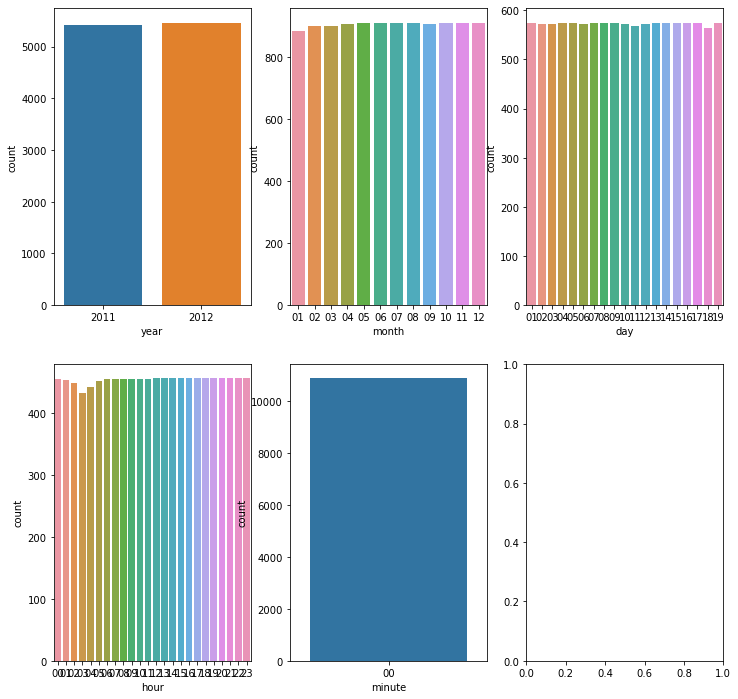

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(2, 3, figsize=(12, 12))

sns.countplot(x='year', data=bike, ax=axes[0][0])
sns.countplot(x='month', data=bike, ax=axes[0][1])
sns.countplot(x='day', data=bike, ax=axes[0][2])
sns.countplot(x='hour', data=bike, ax=axes[1][0])
sns.countplot(x='minute', data=bike, ax=axes[1][1])
# sns.countplot(x='second', data=bike, ax=axes[1][2])

## (4) X, y 컬럼 선택 및 train/test 데이터 분리

second column은 본래 datetime 데이터에는 초가 없으니 minute처럼 00으로 되어 있어야 할 텐데 이상한 값이 들어있어 그래프를 그리는데 문제가 생겼다. `strftime`이 정확히 어떻게 작동하는지 알아야 문제를 해결할 수 있을 듯 하다.  
일단 분, 초는 데이터를 설명하는데 무리가 있고, 회원, 비회원 사용자의 여부도 어쩌피 우리가 알고 싶은 것은 총 랜탈 수이기 떄문에 중요하지 않은 특성일 것이다. 이를 감안하여 dataframe을 다시 조정하자  
그리고 애초에 train, test set을 구분하는 기준이 날짜가 기준이기 떄문에 학습에 날짜 데이터도 이용하면 안될 듯 하다.

In [53]:
bike = bike.drop(['datetime', 'minute', 'second', 'casual', 'registered', 'day'], axis=1)
bike


,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,year,month,hour
0,1,0,0,1,9.84,14.395,81,0.0000,16,2011,01,00
1,1,0,0,1,9.02,13.635,80,0.0000,40,2011,01,01
2,1,0,0,1,9.02,13.635,80,0.0000,32,2011,01,02
3,1,0,0,1,9.84,14.395,75,0.0000,13,2011,01,03
4,1,0,0,1,9.84,14.395,75,0.0000,1,2011,01,04
...,...,...,...,...,...,...,...,...,...,...,...,...
10881,4,0,1,1,15.58,19.695,50,26.0027,336,2012,12,19
10882,4,0,1,1,14.76,17.425,57,15.0013,241,2012,12,20
10883,4,0,1,1,13.94,15.910,61,15.0013,168,2012,12,21
10884,4,0,1,1,13.94,17.425,61,6.0032,129,2012,12,22


In [64]:
y_train = bike['count'].values
X_train = bike.drop('count', axis=1).values

print(X_train.shape, y_train.shape)

(10886, 11) (10886,)


test 데이터를 가져와 train데이터와 똑같이 전처리를 해준다. test 데이터에는 casual, registered columnd이 없는 점이 다르다

In [59]:
bike_test = pd.read_csv("/Users/hanjaemin/Desktop/aiffel/bike-sharing-demand/test.csv")

bike_test['datetime'] = pd.to_datetime(bike_test['datetime'])
bike_test['year'] = bike_test['datetime'].dt.strftime('%Y')
bike_test['month'] = bike_test['datetime'].dt.strftime('%m')
bike_test['hour'] = bike_test['datetime'].dt.strftime('%H')
bike_test = bike_test.drop(['datetime'], axis=1)
y_test= bike_test['count'].values
X_test= bike_test.drop('count', axis=1).values

print(X_test.shape, y_test.shape)


KeyError: 'count'

In [58]:
bike_test = pd.read_csv("/Users/hanjaemin/Desktop/aiffel/bike-sharing-demand/test.csv")

bike_test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


count가 없다는 에러가 나서 확인해 보니 test 데이터에는 target값인 count 열이 없다. kaggle 경진대회니까 정답을 주면 이걸로 학습을 시키면 되니 안주는게 당연하다.. 어쩔 수 없이 train set을 다시 train, test 셋으로 나누는 sklearn.model_seletcion train_test_split 함수를 사용해서 학습을 진행하자

In [65]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2,
random_state=32)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8708, 11) (8708,)
(2178, 11) (2178,)


# (5) LinearRegression 모델 학습
# (6) 학습된 모델로 X_test에 대한 예측값 출력 및 손실함수값 계산


In [78]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(predictions)

from sklearn.metrics import mean_squared_error

mse = mean_squared_error(y_test, predictions)
rmse = mse ** 0.5
print("mse  : %d\nrmse : %d" % (mse, rmse))

[ 93.33244929 193.78245787  52.44961829 ... 215.8551846  236.24324702
 351.74888399]
mse  : 19587
rmse : 139


## (7) x축은 temp 또는 humidity로, y축은 count로 예측 결과 시각화하기
+ x축에 X 데이터 중 temp 데이터를, y축에는 count 데이터를 넣어서 시각화하기
+ x축에 X 데이터 중 humidity 데이터를, y축에는 count 데이터를 넣어서 시각화하기


temp 데이터는 index 가 4 이고 humidity 는 index 가 6이다.

In [94]:
print(list(bike.columns).index('temp'))
print(list(bike.columns).index('humidity'))

4
6


TypeError: 'AxesSubplot' object is not subscriptable

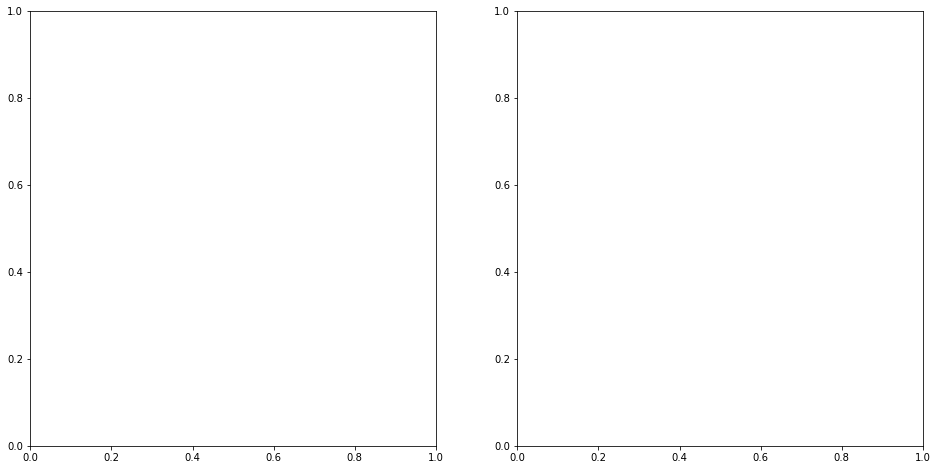

In [100]:
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
sns.scatterplot(X_test[:, 4], y_test, label="true", ax=axes[0][0])
sns.scatterplot(X_test[:, 4], predictions, label="pred", ax=axes[0][1])


에러를 보고  
[sns.scatterplot](https://seaborn.pydata.org/generated/seaborn.scatterplot.html?highlight=scatterplot#seaborn.scatterplot)  
를 들어가보니 sns.scatterplot은 pandas의 dataframe을 넣어야 제대로 작동하는 것 같다. 이를 위해 새로운 dataframe을 만들고 거기에 X_test의 4, 6번째 열에 상대온도, 습도로 넣고 y_test와 precdictions 을 각각 넣어주자

In [123]:
_dict = {"temp": X_test[:, 4], "humidity": X_test[:, 6], "y_test": y_test,
 "pred": predictions}

In [124]:
df = pd.DataFrame(_dict)

[그래프 그릴 때 참고함](https://www.tutorialspoint.com/matplotlib/matplotlib_axes_class.htm)

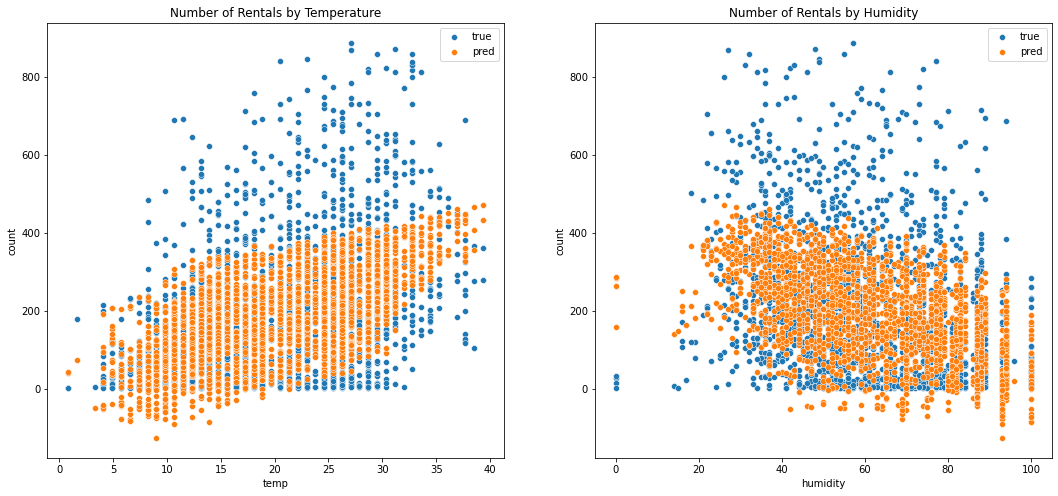

In [176]:

fig, axes = plt.subplots(1, 2, figsize = (18 ,8))


sns.scatterplot(data=df, x='temp', y='y_test', ax=axes[0])
sns.scatterplot(data=df, x='temp', y='pred', ax=axes[0])
axes[0].set_ylabel('count')
axes[0].legend(labels=["true", "pred"])
axes[0].set_title("Number of Rentals by Temperature")

sns.scatterplot(data=df, x='humidity', y='y_test', ax=axes[1])
sns.scatterplot(data=df, x='humidity', y='pred', ax=axes[1])
axes[1].set_ylabel('count')
axes[1].legend(labels=["true", "pred"])
axes[1].set_title("Number of Rentals by Humidity")

plt.show()

### 회고

금요일 2시간, 퇴근 후 집에서 2시간 토요일 오늘 집에서 2시간 해서 총 6시간 정도 걸린 것 같다. 처음에는 간단할 것이라 생각했지만 은근히 datetime에 대해서 찾아보고 pandas dataframe을 다루는 법을 다시 공부하면서 시간이 많이 걸렸다.  
또한 seaborn을 사용하여 scatter그래프를 그리려 하였는데 plt.scatter 그래프와 다른 부분도 있고 기존 matplotlib 의 axes class에 대한 이해가 부족해서인지 그래프를 그리는데 어려움이 있었다.  

출력 결과를 보면 의아한게 습도는 높을수록 렌트량이 감소하는 음의 상관관계가 잘 나타나는 것처럼 보이는데 온도는 반대로 양의 상관관계를 띈다. 내 생각에는 선선한 날씨인 10 ~ 20 섭씨온도 사이가 가장 많아야 할 것 같은데 약간 의외인 것 같다.  

확실히 직접 데이터를 가지고 조금이나마 프레임워크를 사용해 보는게 그 프레임워크를 익히는데 가장 좋은 방법인 것 같다. 지금도 이렇게 시간이 걸리는데 점점 어려워지면 어떻게 하지 걱정이 들기도 하지만 지금 당장은 재밋으니 일단 제쳐두기로 하자, ㅍㅇㅌ~